In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, make_scorer, f1_score,
    precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

# Load the feature matrix
df = pd.read_parquet(r"C:\BIOE5860_Data\MODEL_READY_MATRIX.parquet")

print(f"Loaded matrix: {df.shape}")
print(f"  Label=1 (AD): {(df['LABEL']==1).sum()}")
print(f"  Label=0 (Control): {(df['LABEL']==0).sum()}")

# Separate features and target
feature_cols = [c for c in df.columns if c not in ['SUBJECT_ID', 'LABEL']]
X = df[feature_cols]
y = df['LABEL']

#hit memory limits so convert to sparse matrix and float32. Shouldn't lose much precision since these are mostly binary features.
X = X.astype(np.float32)
X_sparse = csr_matrix(X.values)


print(f"Features: {X.shape[1]}")

Loaded matrix: (46503, 11742)
  Label=1 (AD): 343
  Label=0 (Control): 46160
Features: 11740


In [2]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, zero_division=0),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'roc_auc': 'roc_auc',
}

print(f"Cross-validation: {N_FOLDS}-fold stratified")
print(f"Positive class prevalence: {y.mean():.4f}")

Cross-validation: 5-fold stratified
Positive class prevalence: 0.0074


In [3]:
dt = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=10,          # Prevent overfitting on sparse features
    min_samples_leaf=20,   # Ensure leaves have enough samples
    random_state=42
)

print("Training Decision Tree with cross-validation...")
dt_cv = cross_validate(
    dt, X_sparse, y,
    cv=skf,
    scoring=scoring,
    return_estimator=True,  # Keep fitted models for feature importance
    n_jobs=-1
)

print("\nDecision Tree Results (mean +/- std across folds):")
for metric in scoring:
    scores = dt_cv[f'test_{metric}']
    print(f"  {metric}: {scores.mean():.4f} +/- {scores.std():.4f}")

# Average feature importances across folds
dt_importances = np.mean(
    [est.feature_importances_ for est in dt_cv['estimator']],
    axis=0
)

dt_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_importances
}).sort_values('importance', ascending=False)

print(f"\nNon-zero importance features: {(dt_importances > 0).sum()}")

Training Decision Tree with cross-validation...

Decision Tree Results (mean +/- std across folds):
  accuracy: 0.8633 +/- 0.0079
  f1: 0.0670 +/- 0.0087
  precision: 0.0353 +/- 0.0046
  recall: 0.6617 +/- 0.0655
  roc_auc: 0.8008 +/- 0.0356

Non-zero importance features: 181


In [4]:
# Lasso needs scaled features for proper regularization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LogisticRegression(
    penalty='l1',
    solver='saga',
    class_weight='balanced',
    max_iter=5000,
    C=1.0,               # Regularization strength (lower = more regularization)
    random_state=42,
    n_jobs=-1
)

print("Training Lasso (L1 Logistic Regression) with cross-validation...")
lasso_cv = cross_validate(
    lasso, X_scaled, y,
    cv=skf,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

print("\nLasso Results (mean +/- std across folds):")
for metric in scoring:
    scores = lasso_cv[f'test_{metric}']
    print(f"  {metric}: {scores.mean():.4f} +/- {scores.std():.4f}")

# Average absolute coefficients across folds
lasso_coefs = np.mean(
    [np.abs(est.coef_[0]) for est in lasso_cv['estimator']],
    axis=0
)

lasso_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lasso_coefs
}).sort_values('importance', ascending=False)

print(f"\nNon-zero coefficient features: {(lasso_coefs > 0).sum()}")

Training Lasso (L1 Logistic Regression) with cross-validation...

Lasso Results (mean +/- std across folds):
  accuracy: 0.9132 +/- 0.0041
  f1: 0.1114 +/- 0.0069
  precision: 0.0603 +/- 0.0037
  recall: 0.7377 +/- 0.0610
  roc_auc: 0.8919 +/- 0.0367

Non-zero coefficient features: 11537


Accuracy = correct predictions/total predictions

precision = PPV

recall = sensitivity (true pos / total pos)

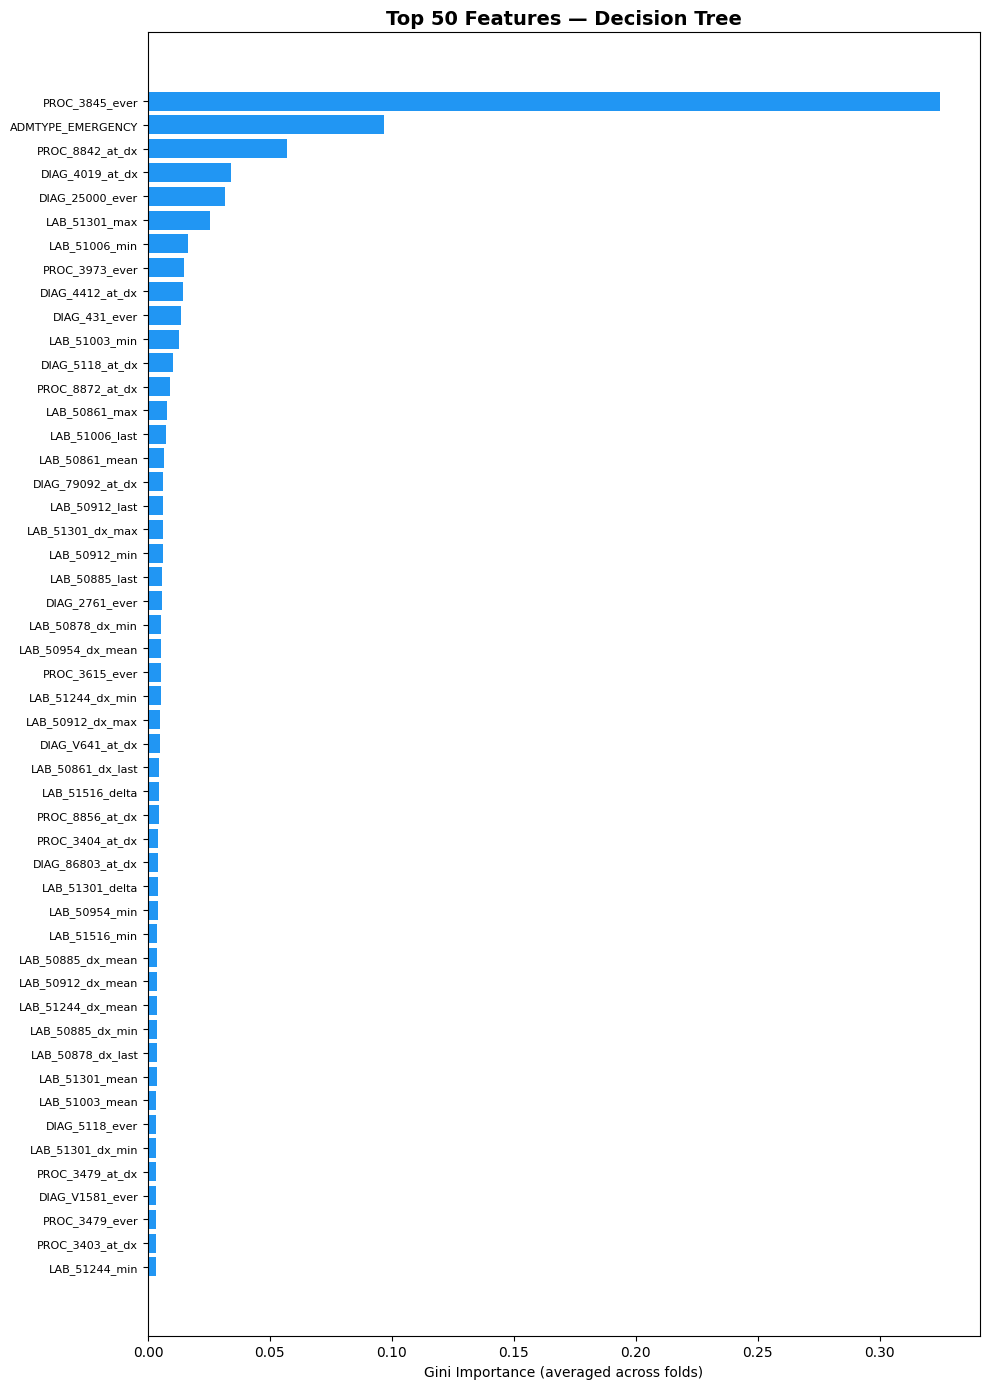

Saved: DT_Top50_Features.png


In [5]:
TOP_N = 50

dt_top = dt_importance_df.head(TOP_N).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 14))
ax.barh(dt_top['feature'], dt_top['importance'], color='#2196F3')
ax.set_xlabel('Gini Importance (averaged across folds)')
ax.set_title(f'Top {TOP_N} Features — Decision Tree', fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.savefig(r"C:\BIOE5860_Data\DT_Top50_Features.png", dpi=150, bbox_inches='tight')
plt.show()

print("Saved: DT_Top50_Features.png")

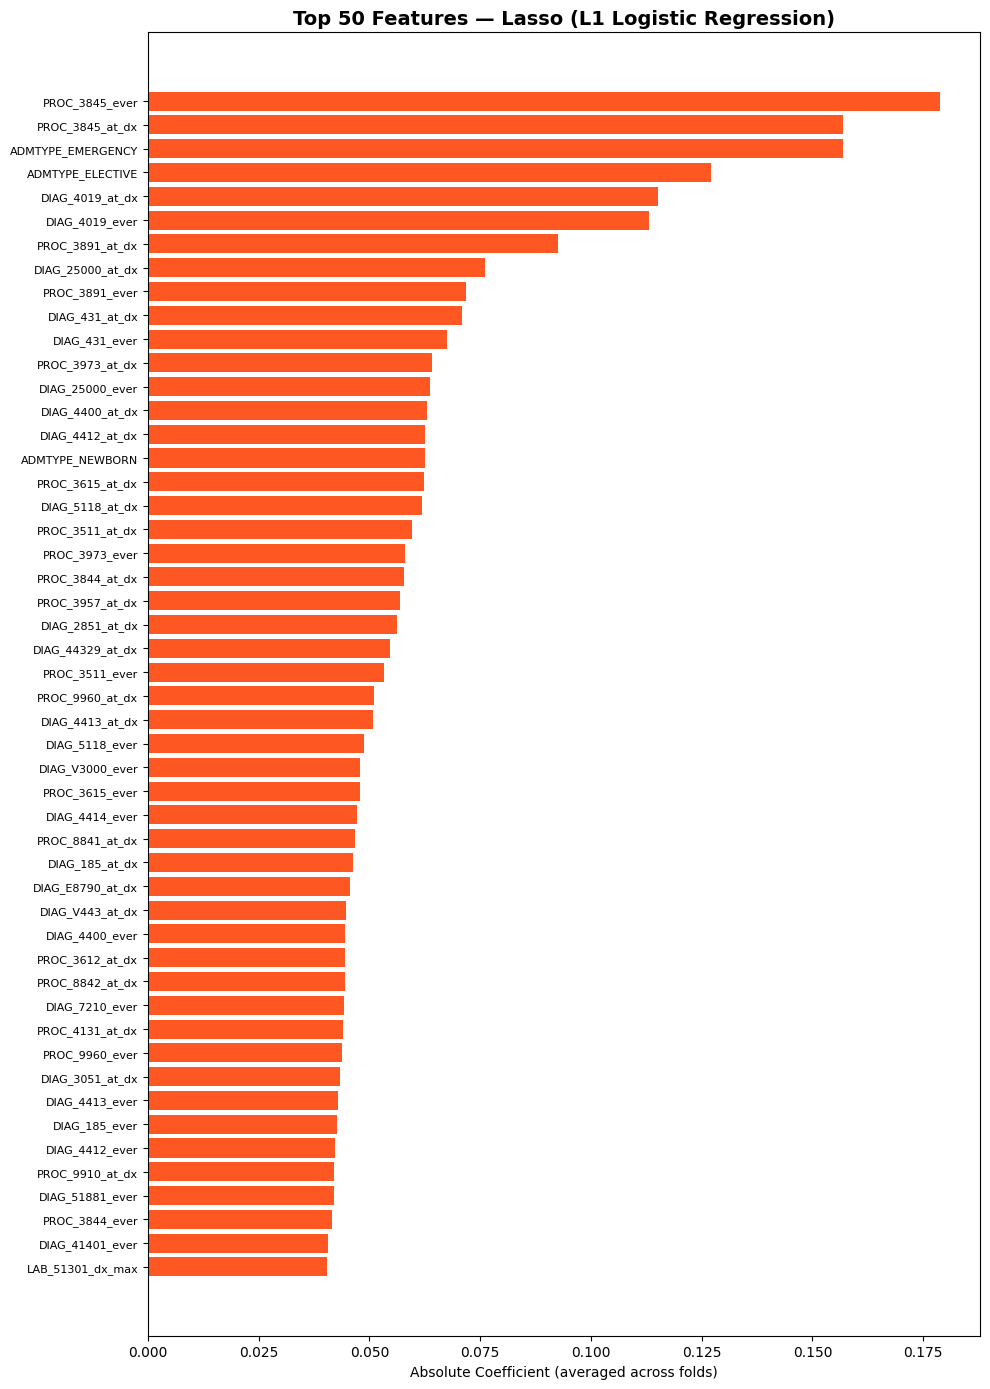

Saved: Lasso_Top50_Features.png


In [6]:
lasso_top = lasso_importance_df.head(TOP_N).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 14))
ax.barh(lasso_top['feature'], lasso_top['importance'], color='#FF5722')
ax.set_xlabel('Absolute Coefficient (averaged across folds)')
ax.set_title(f'Top {TOP_N} Features — Lasso (L1 Logistic Regression)', fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.savefig(r"C:\BIOE5860_Data\Lasso_Top50_Features.png", dpi=150, bbox_inches='tight')
plt.show()

print("Saved: Lasso_Top50_Features.png")

In [7]:
# Show overlap between the two models' top 50
dt_top50_set = set(dt_importance_df.head(TOP_N)['feature'])
lasso_top50_set = set(lasso_importance_df.head(TOP_N)['feature'])
overlap = dt_top50_set & lasso_top50_set

print(f"\nTop {TOP_N} overlap between Decision Tree and Lasso:")
print(f"  Features in both: {len(overlap)}")
print(f"  Only in Decision Tree: {len(dt_top50_set - lasso_top50_set)}")
print(f"  Only in Lasso: {len(lasso_top50_set - dt_top50_set)}")
print(f"\nShared features:")
for f in sorted(overlap):
    print(f"  {f}")

# Export full importance rankings
dt_importance_df.to_csv(
    r"C:\BIOE5860_Data\DT_Feature_Importances.csv", index=False
)
lasso_importance_df.to_csv(
    r"C:\BIOE5860_Data\Lasso_Feature_Importances.csv", index=False
)

print("\nSaved full importance rankings as CSV.")


Top 50 overlap between Decision Tree and Lasso:
  Features in both: 12
  Only in Decision Tree: 38
  Only in Lasso: 38

Shared features:
  ADMTYPE_EMERGENCY
  DIAG_25000_ever
  DIAG_4019_at_dx
  DIAG_431_ever
  DIAG_4412_at_dx
  DIAG_5118_at_dx
  DIAG_5118_ever
  LAB_51301_dx_max
  PROC_3615_ever
  PROC_3845_ever
  PROC_3973_ever
  PROC_8842_at_dx

Saved full importance rankings as CSV.


In [8]:
# Use the last fold's estimator for a detailed report
dt_last = dt_cv['estimator'][-1]
lasso_last = lasso_cv['estimator'][-1]

# Get the last fold's test indices
fold_indices = list(skf.split(X_sparse, y))
_, test_idx = fold_indices[-1]

X_test_fold = X.iloc[test_idx]
X_test_fold_scaled = X_scaled[test_idx]
y_test_fold = y.iloc[test_idx]

print("=" * 60)
print("Decision Tree — Classification Report (last fold)")
print("=" * 60)
dt_pred = dt_last.predict(X_test_fold)
print(classification_report(y_test_fold, dt_pred, target_names=['Control', 'AD']))

print("=" * 60)
print("Lasso — Classification Report (last fold)")
print("=" * 60)
lasso_pred = lasso_last.predict(X_test_fold_scaled)
print(classification_report(y_test_fold, lasso_pred, target_names=['Control', 'AD']))

Decision Tree — Classification Report (last fold)
              precision    recall  f1-score   support

     Control       1.00      0.88      0.94      9232
          AD       0.04      0.71      0.08        68

    accuracy                           0.88      9300
   macro avg       0.52      0.79      0.51      9300
weighted avg       0.99      0.88      0.93      9300

Lasso — Classification Report (last fold)
              precision    recall  f1-score   support

     Control       1.00      0.91      0.95      9232
          AD       0.06      0.82      0.12        68

    accuracy                           0.91      9300
   macro avg       0.53      0.87      0.54      9300
weighted avg       0.99      0.91      0.95      9300

